## Imports and Setup

In [1]:
# Reproducibility
import random
from pathlib import Path
import sys
import os

RANDOM_SEED = 42
random.seed(RANDOM_SEED)

# Project root (folder that contains "data/")
PROJECT_ROOT = Path(r"C:\Users\tengc\Downloads\metrics-eval\metrics_eval")

# .env lives one level above metrics_eval (based on what you said)
ENV_PATH = PROJECT_ROOT.parent / ".env"

print("PROJECT_ROOT:", PROJECT_ROOT)
print(".env path:", ENV_PATH)
print("PROJECT_ROOT exists:", PROJECT_ROOT.exists())
print(".env exists:", ENV_PATH.exists())

PROJECT_ROOT: C:\Users\tengc\Downloads\metrics-eval\metrics_eval
.env path: C:\Users\tengc\Downloads\metrics-eval\.env
PROJECT_ROOT exists: True
.env exists: True


In [2]:
from dotenv import load_dotenv

if ENV_PATH.exists():
    load_dotenv(dotenv_path=ENV_PATH)
    print(f"Loaded .env: {ENV_PATH}")
else:
    print("WARNING: .env not found. Make sure OPENAI_API_KEY and ANTHROPIC_API_KEY are set.")

print("OPENAI_API_KEY found:", bool(os.environ.get("OPENAI_API_KEY")))
print("ANTHROPIC_API_KEY found:", bool(os.environ.get("ANTHROPIC_API_KEY")))

Loaded .env: C:\Users\tengc\Downloads\metrics-eval\.env
OPENAI_API_KEY found: True
ANTHROPIC_API_KEY found: True


In [3]:
SUM_SCRIPTS_DIR = PROJECT_ROOT / "models" / "summarising" / "scripts"
sys.path.append(str(SUM_SCRIPTS_DIR))

import pipeline  # your patched pipeline.py

print("Imported pipeline from:", pipeline.__file__)

Imported pipeline from: C:\Users\tengc\Downloads\metrics-eval\metrics_eval\models\summarising\scripts\pipeline.py


## Experiment Config

In [4]:
# INPUT POOL: point this to your synthetic jsonl OR processed input jsonl
# If you generated synth inputs, it usually looks like:
#   data/summarising/val/synth_inputs.jsonl
# Make sure it has id/raw_text OR Comment_ID/Comment.
INPUT_PATH = PROJECT_ROOT / "data" / "summarising" / "val" / "synth_inputs.jsonl"

# Where model outputs will go (per model subfolder)
RESULTS_DIR = PROJECT_ROOT / "models" / "summarising" / "results"

# Where expert validation Excel goes
EXPERT_DIR = RESULTS_DIR / "expert_val"
EXPERT_DIR.mkdir(parents=True, exist_ok=True)

# Models (add more later)
GPT_MODEL = "gpt-5"
CLAUDE_MODEL = "claude-sonnet-4-5"

MODELS = [GPT_MODEL, CLAUDE_MODEL]

print("INPUT_PATH:", INPUT_PATH)
print("INPUT exists:", INPUT_PATH.exists())
print("RESULTS_DIR:", RESULTS_DIR)
print("EXPERT_DIR:", EXPERT_DIR)
print("MODELS:", MODELS)

INPUT_PATH: C:\Users\tengc\Downloads\metrics-eval\metrics_eval\data\summarising\val\synth_inputs.jsonl
INPUT exists: True
RESULTS_DIR: C:\Users\tengc\Downloads\metrics-eval\metrics_eval\models\summarising\results
EXPERT_DIR: C:\Users\tengc\Downloads\metrics-eval\metrics_eval\models\summarising\results\expert_val
MODELS: ['gpt-5', 'claude-sonnet-4-5']


## Run Experiment

In [5]:
# FULL RUN
TEST_MODE = False
MAX_ROWS = 30  # ignored if TEST_MODE=False
SLEEP_SEC = 0.0

for model_name in MODELS:
    model_out_dir = RESULTS_DIR / model_name.replace("/", "_")
    model_out_dir.mkdir(parents=True, exist_ok=True)

    print("\n========================================")
    print("Running model:", model_name)
    print("Saving to:", model_out_dir)

    pipeline.run_summarising_pipeline(
        input_path=INPUT_PATH,
        output_dir=model_out_dir,
        test_mode=TEST_MODE,
        max_rows=MAX_ROWS,
        model=model_name,
        sleep_sec=SLEEP_SEC,
    )


Running model: gpt-5
Saving to: C:\Users\tengc\Downloads\metrics-eval\metrics_eval\models\summarising\results\gpt-5
📥 Loading processed data from: C:\Users\tengc\Downloads\metrics-eval\metrics_eval\data\summarising\val\synth_inputs.jsonl
Rows in dataset: 200

--- Row 0 (Comment_ID=summary_synth_0) ---
Input: The gaskets arrived but wrong material specification, we ordered Viton but received EPDG instead. Can you check the order form on your side and arrange replacement urgent? Our installation scheduled for Thursday cannot delay.
JSON output: {'improvement_comment': 'Verify the order and urgently send Viton gaskets to replace the incorrect EPDG ones.'}

--- Row 1 (Comment_ID=summary_synth_1) ---
Input: The gasket material you supplied is not meeting the temperature spec we discussed during our meeting last month. Already had one failure during pressure testing and need immediate replacement plus confirmation that new batch can handle 180 degrees continuous operation. Please respond to

## Load Outputs

In [6]:
import json
import pandas as pd

def read_predictions(jsonl_path: Path) -> pd.DataFrame:
    rows = []
    with jsonl_path.open("r", encoding="utf-8") as f:
        for line in f:
            obj = json.loads(line)
            out = (obj.get("model_output") or {}).get("improvement_comment", "")
            rows.append({
                "Comment_ID": obj.get("Comment_ID"),
                "input": obj.get("Comment", ""),
                "output": out if out is not None else "",
                "model": obj.get("model", ""),
            })
    return pd.DataFrame(rows)

model_dfs = {}

for model_name in MODELS:
    model_dir = RESULTS_DIR / model_name.replace("/", "_")
    pred_path = model_dir / "cx_improvement_full.jsonl"
    assert pred_path.exists(), f"Missing output: {pred_path}"

    df = read_predictions(pred_path)
    model_dfs[model_name] = df
    print(model_name, "rows:", len(df))

model_dfs[GPT_MODEL].head(3)

gpt-5 rows: 200
claude-sonnet-4-5 rows: 200


,Comment_ID,input,output,model
0,summary_synth_0,The gaskets arrived but wrong material specifi...,Verify the order and urgently send Viton gaske...,gpt-5
1,summary_synth_1,The gasket material you supplied is not meetin...,Replace the gaskets immediately and confirm th...,gpt-5
2,summary_synth_2,Just want to highlight that your technical tea...,Reissue the invoice to match the revised quota...,gpt-5


## Metrics

In [7]:
BAD = {"NONE", "ERROR", ""}

def compute_nonexpert_metrics(df: pd.DataFrame) -> dict:
    outs = df["output"].astype(str).str.strip()
    valid = ~outs.isin(BAD)

    coverage = float(valid.mean()) if len(df) else 0.0
    valid_outs = outs[valid]

    # duplicate rate among valid outputs
    dup_rate = 0.0
    if len(valid_outs) > 0:
        dup_rate = 1.0 - (valid_outs.nunique() / len(valid_outs))

    metrics = {
        "n_rows": int(len(df)),
        "valid_output_pct": round(coverage * 100, 2),
        "avg_output_len_chars": round(valid_outs.str.len().mean(), 2) if len(valid_outs) else 0.0,
        "median_output_len_chars": float(valid_outs.str.len().median()) if len(valid_outs) else 0.0,
        "duplicate_rate_valid_outputs_pct": round(dup_rate * 100, 2),
    }
    return metrics

metrics_rows = []
for model_name, df in model_dfs.items():
    m = compute_nonexpert_metrics(df)
    m["model"] = model_name
    metrics_rows.append(m)

metrics_df = pd.DataFrame(metrics_rows).sort_values("model")
metrics_df

,n_rows,valid_output_pct,avg_output_len_chars,median_output_len_chars,duplicate_rate_valid_outputs_pct,model
1,200,100.0,140.96,145.0,4.5,claude-sonnet-4-5
0,200,96.5,89.12,87.0,0.0,gpt-5


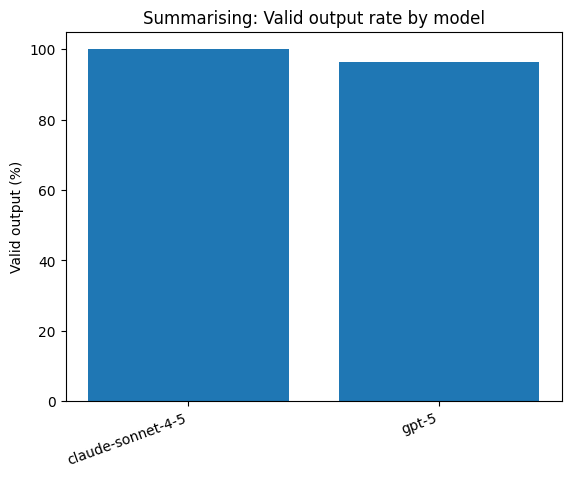

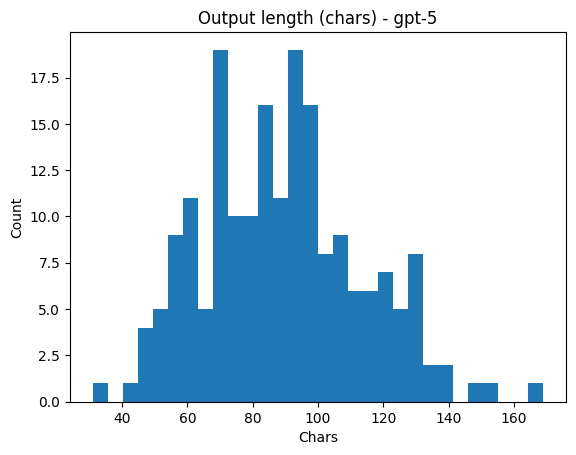

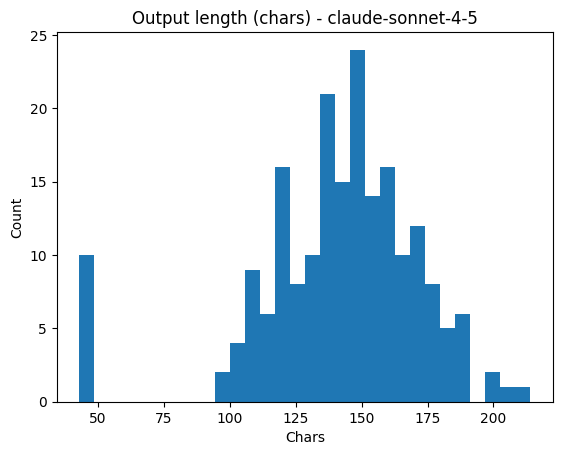

In [8]:
import matplotlib.pyplot as plt

# Coverage chart
plt.figure()
plt.bar(metrics_df["model"], metrics_df["valid_output_pct"])
plt.xticks(rotation=20, ha="right")
plt.ylabel("Valid output (%)")
plt.title("Summarising: Valid output rate by model")
plt.show()

# Output length histogram for each model (separate plots to keep it readable)
for model_name, df in model_dfs.items():
    valid = ~df["output"].astype(str).str.strip().isin(BAD)
    lengths = df.loc[valid, "output"].astype(str).str.len()

    plt.figure()
    plt.hist(lengths, bins=30)
    plt.title(f"Output length (chars) - {model_name}")
    plt.xlabel("Chars")
    plt.ylabel("Count")
    plt.show()

In [9]:
metrics_csv = RESULTS_DIR / "nonexpert_metrics_summary.csv"
metrics_df.to_csv(metrics_csv, index=False)
print("Saved:", metrics_csv)

Saved: C:\Users\tengc\Downloads\metrics-eval\metrics_eval\models\summarising\results\nonexpert_metrics_summary.csv


## Metrics: Expert Validation

In [10]:
from openpyxl import Workbook
from openpyxl.utils.dataframe import dataframe_to_rows

# How many samples PER MODEL to send to client
SAMPLE_N = 30

def sample_df(df: pd.DataFrame, n: int, seed: int = 42) -> pd.DataFrame:
    if len(df) <= n:
        return df.copy()
    return df.sample(n=n, random_state=seed).copy()

def make_expert_sheet_df(df: pd.DataFrame, output_col_name: str) -> pd.DataFrame:
    # Rename output to model-specific column name (output_gpt or output_claude)
    out = df.copy()
    out = out.rename(columns={"output": output_col_name})

    # Keep only needed columns first
    out = out[["Comment_ID", "input", output_col_name]]

    # Add Likert rating columns (client fills)
    out["Actionability (1-5)"] = ""
    out["Relevance (1-5)"] = ""
    out["Completeness (1-5)"] = ""
    out["Conciseness (1-5)"] = ""

    # Correctness precision columns (optional but from your report)
    out["Correct_Elements"] = ""
    out["Generated_Elements"] = ""

    # Notes
    out["Notes"] = ""
    return out

gpt_sample = sample_df(model_dfs[GPT_MODEL], SAMPLE_N, RANDOM_SEED)
claude_sample = sample_df(model_dfs[CLAUDE_MODEL], SAMPLE_N, RANDOM_SEED)

gpt_sheet = make_expert_sheet_df(gpt_sample, output_col_name="output_gpt")
claude_sheet = make_expert_sheet_df(claude_sample, output_col_name="output_claude")

out_xlsx = EXPERT_DIR / "summarising_expert_validation.xlsx"

wb = Workbook()

# ReadMe
ws = wb.active
ws.title = "ReadMe"
readme_lines = [
    "How to fill this workbook:",
    "1) Each sheet contains model outputs for the same task (Summarising).",
    "2) For each row, rate the output from 1–5 on:",
    "   - Actionability, Relevance, Completeness, Conciseness.",
    "3) If output is NONE/ERROR/unusable, rate 1 and optionally note why.",
    "4) (Optional) Fill Correct_Elements and Generated_Elements to compute correctness precision:",
    "   correctness_precision = Correct_Elements / Generated_Elements.",
]
for i, line in enumerate(readme_lines, start=1):
    ws.cell(row=i, column=1, value=line)

# GPT sheet
ws_gpt = wb.create_sheet(title="GPT")
for r in dataframe_to_rows(gpt_sheet, index=False, header=True):
    ws_gpt.append(r)

# Claude sheet
ws_claude = wb.create_sheet(title="Claude")
for r in dataframe_to_rows(claude_sheet, index=False, header=True):
    ws_claude.append(r)

wb.save(out_xlsx)
print("Saved expert workbook to:", out_xlsx)

Saved expert workbook to: C:\Users\tengc\Downloads\metrics-eval\metrics_eval\models\summarising\results\expert_val\summarising_expert_validation.xlsx
